# Ручная реализация описанных методов.

In [4]:
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import scipy.stats as sps
from scipy.optimize import minimize
from scipy.sparse.linalg import svds

import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm.notebook import tqdm

## Загрузка датасета

In [5]:
dataset = "heart.txt"
dataset = "australian.txt"

dataset = load_svmlight_file(dataset)
A = dataset[0]
X, y = A.toarray(), dataset[1]

In [6]:
input_dim = X.shape[1]
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
X.min(), X.max()

(-1.0, 1.0000000000000004)

## Модель Logistic regression

## Jax version

In [72]:
import jax
import jax.numpy as jnp

class LinearSGD:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + jnp.exp(-x))

    def __init__(self, input_dim):
        self.W = jnp.zeros((input_dim, 1))
        self.logger = list()

    def reset_logger(self):
        self.logger = list()

    def apply(self, X):
        return X @ self.W

    def predict(self, X):
        probs = self.sigmoid(self.apply(X))
        return (probs >= 0.5).astype(int) * 2 - 1

    @staticmethod
    def jax_loss(W, X, y):
        logits = (X @ W).ravel()
        log_loss = jnp.logaddexp(0, -y * logits).mean()
        return log_loss

    def loss(self, X, y):
        return self.jax_loss(self.W, X, y)

    def gradient_step(self, X, y, lr=0.01, clip_value=None, noise=None):
        y = y.reshape(-1, 1)

        loss_grad_fn = jax.grad(self.jax_loss, argnums=0)
        grad = loss_grad_fn(self.W, X, y)

        self.logger.append(jnp.linalg.norm(grad.flatten()))

        if noise is not None:
            grad += noise

        if clip_value is not None:
            norm = jnp.linalg.norm(grad)
            if norm > clip_value:
                grad *= clip_value / norm

        self.W -= lr * grad

In [73]:
from jax.scipy.optimize import minimize

f_star = LinearSGD(input_dim)

I = np.zeros(X.shape[1])
W_star = minimize(f_star.jax_loss, I, args=(X, y), method="BFGS").x
f_star.W = W_star

f_star = f_star.loss(X, y)
print(f_star)
W_star

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/lax_numpy.py:4905: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  output = _eye(N, M=M, k=k, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


0.32142016


Array([ 0.04598261,  0.16891769, -0.49515215,  0.90455735,  1.2921468 ,
        0.22878845,  0.5450694 ,  1.7794356 ,  0.4758253 ,  0.59870845,
       -0.10639998,  0.598642  , -2.9998896 ,  2.0640466 ], dtype=float32)

In [ ]:
def delta_f(model):
    return model.loss(X, y) - f_star

In [ ]:
n_exp = 10000

lr = 0.5
init_clip_value = 0.001
def update_clip_value(clip_value, i=1):
    return clip_value

log_grad = defaultdict(list)
log_delta_f = defaultdict(list)

heavy_noise = sps.cauchy(loc=0, scale=0.001).rvs(size=(n_exp, 14, 1), random_state=30)
light_noise = sps.norm(loc=0, scale=0.001).rvs(size=(n_exp, 14, 1), random_state=30)
no_noise = None

train_setup = [
    ("SGD", LinearSGD(input_dim), None, no_noise),
    ("SGD Light Noise", LinearSGD(input_dim), None, light_noise),
    ("SGD Heavy Noise", LinearSGD(input_dim), None, heavy_noise),
    ("Clipped SGD", LinearSGD(input_dim), init_clip_value, no_noise),
    ("Clipped SGD Light Noise", LinearSGD(input_dim), init_clip_value, light_noise),
    ("Clipped SGD Heavy Noise", LinearSGD(input_dim), init_clip_value, heavy_noise),
]

for name, model, clip_value, noise in train_setup:
    np.random.seed(30)

    for i in tqdm(range(n_exp)):
        indecies = np.arange(0, X.shape[0])
        noise_value = noise[i] if noise is not None else None
        model.gradient_step(X[indecies],
                            y[indecies],
                            lr=lr,
                            clip_value=clip_value,
                            noise=noise_value)
        clip_value = update_clip_value(clip_value)
        if i % 10 == 0:
            log_delta_f[name].append(delta_f(model))
    log_grad[name] = np.array(model.logger) ** 2

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

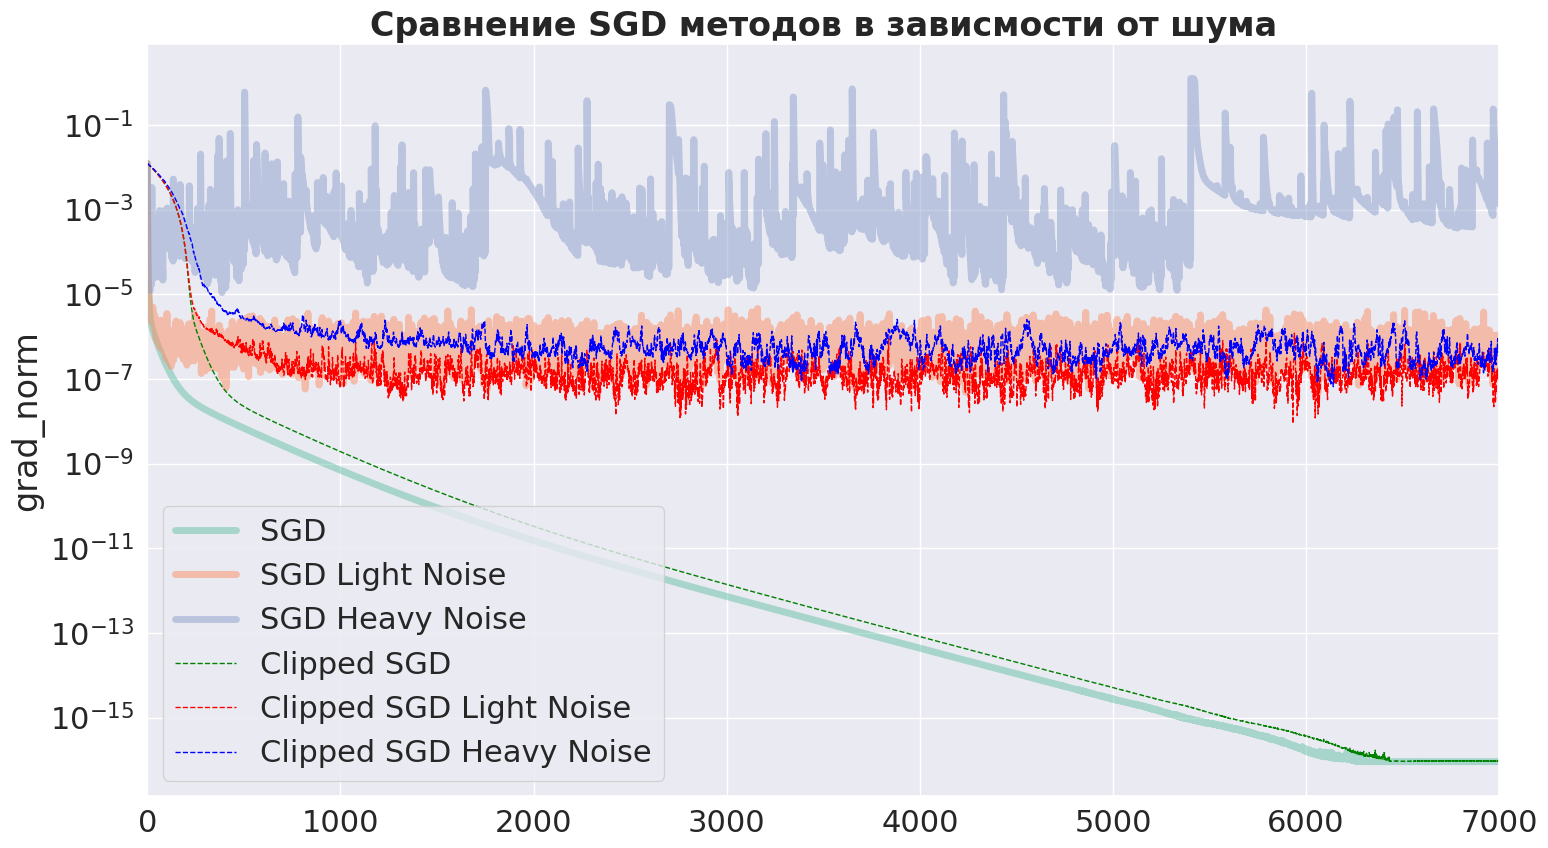

In [ ]:
import seaborn as sns

sns.set_context("notebook")
sns.set_style("darkgrid")
sns.set(font_scale=2)

plt.figure(figsize=(16, 9))
plt.title("Сравнение SGD методов в зависмости от шума", fontweight="bold")
start_pos = 0
plt.ylabel(r"grad_norm")
colors = sns.color_palette("Set2")[:3] + ["green", "red", "blue"]
for i, (name, model, clip_value, noise) in enumerate(train_setup):
    linestyle = "--" if "Clipped" in name else '-'
    alpha = 1 if "Clipped" in name else 0.5
    lw = 1 if "Clipped" in name else 5
    plt.semilogy(log_grad[name][start_pos:], label=name, alpha=alpha, lw=lw,
                 linestyle=linestyle, color=colors[i])
plt.xlim((0, 7000))
plt.legend()
plt.tight_layout()

plt.savefig('problem_illustration.svg')

plt.show()

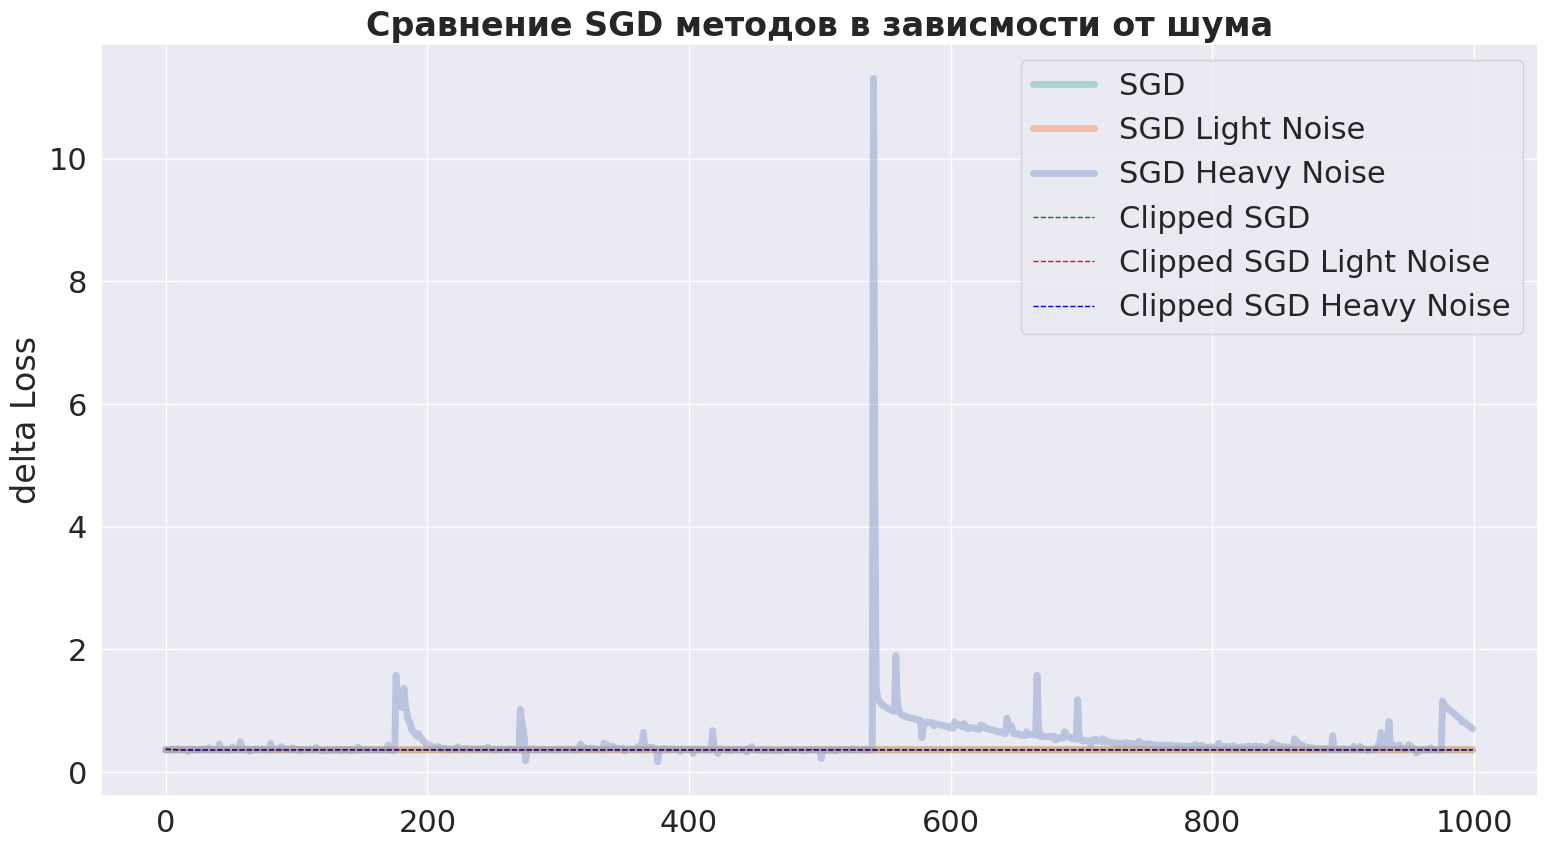

In [ ]:
import seaborn as sns

sns.set_context("notebook")
sns.set_style("darkgrid")
sns.set(font_scale=2)

plt.figure(figsize=(16, 9))
plt.title("Сравнение SGD методов в зависмости от шума", fontweight="bold")
start_pos = 0
plt.ylabel(r"delta Loss")
colors = sns.color_palette("Set2")[:3] + ["green", "red", "blue"]
for i, (name, model, clip_value, noise) in enumerate(train_setup):
    linestyle = "--" if "Clipped" in name else '-'
    alpha = 1 if "Clipped" in name else 0.5
    lw = 1 if "Clipped" in name else 5
    plt.plot(log_delta_f[name][start_pos:], label=name, alpha=alpha, lw=lw,
             linestyle=linestyle, color=colors[i])
plt.savefig('loss_illustration.svg')
plt.legend()
plt.tight_layout()
plt.show()

# SSTM

In [7]:
def compute_L(X):
    _, sv, _ = np.linalg.svd(X.T @ X, full_matrices=False)
    return sv[0] / (4 * 1)

compute_L(X)

727.1788772557641

In [126]:
import jax
import jax.numpy as jnp

class LinearSSTM:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + jnp.exp(-x))

    def __init__(self, input_dim):
        self.W = jnp.zeros((input_dim, 1))
        self.logger = list()

    def reset_logger(self):
        self.logger = list()

    def apply(self, X):
        return X @ self.W

    def predict(self, X):
        probs = self.sigmoid(self.apply(X))
        return (probs >= 0.5).astype(int) * 2 - 1

    @staticmethod
    def jax_loss(W, X, y):
        logits = (X @ W).ravel()
        log_loss = jnp.logaddexp(0, -y * logits).mean()
        return log_loss

    def loss(self, X, y):
        return self.jax_loss(self.W, X, y)

    def gradient_step(self, x_k_plus_1, X, y, lr=0.01, clip_value=None, noise=None):
        y = y.reshape(-1, 1)

        loss_grad_fn = jax.grad(self.jax_loss, argnums=0)
        grad = loss_grad_fn(x_k_plus_1, X, y)

        self.logger.append(jnp.linalg.norm(grad.flatten()))

        if noise is not None:
            grad += noise

        if clip_value is not None:
            norm = jnp.linalg.norm(grad)
            if norm > clip_value:
                grad *= clip_value / norm

        self.W -= lr * grad

In [127]:
N = 50_000
heavy_noise = sps.cauchy(loc=0, scale=0.001).rvs(size=(N, 14, 1), random_state=30)
light_noise = sps.norm(loc=0, scale=0.001).rvs(size=(N, 14, 1), random_state=30)
no_noise = None

noise = heavy_noise

In [128]:
N = 2000
save_grad = dict()
train_setup = [
    ("SSTM", None, no_noise),
    ("SSTM Light Noise", None, light_noise),
    ("SSTM Heavy Noise", None, heavy_noise),
    ("Clipped SSTM",             0.01, no_noise),
    ("Clipped SSTM Light Noise", 0.01, light_noise),
    ("Clipped SSTM Heavy Noise", 0.01, heavy_noise),
]

for name, B, noise in train_setup:
    model = LinearSSTM(input_dim)
    a = 1
    L = 1

    A_0 = alpha_0 = 0
    y_0 = z_0 = x_0 = model.W

    A_k = alpha_k = 0
    y_k = z_k = x_k = model.W

    grad_norm = list()

    for k in tqdm(range(N)):
        alpha_k_plus_1 = (k + 2) / (2 * a * L)
        A_k_plus_1 = A_k + alpha_k_plus_1
        if B is not None:
            lambda_k_plus_1 = B / alpha_k_plus_1

        x_k_plus_1 = (A_k * y_k + alpha_k_plus_1 * z_k) / A_k_plus_1
        grad = jax.grad(model.jax_loss, argnums=0)(x_k_plus_1, X, y.reshape(-1, 1))

        grad_norm.append(jnp.linalg.norm(grad))

        if noise is not None:
            grad += noise[k]
        if B is not None:
            norm = jnp.linalg.norm(grad)
            if norm > lambda_k_plus_1:
                grad *= lambda_k_plus_1 / norm
        z_k_plus_1 = z_k - alpha_k_plus_1 * grad
        y_k_plus_1 = (A_k * y_k + alpha_k_plus_1 * z_k_plus_1) / A_k_plus_1

        A_k = A_k_plus_1
        alpha_k = alpha_k_plus_1
        y_k = y_k_plus_1
        z_k = z_k_plus_1
    save_grad[name] = grad_norm

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

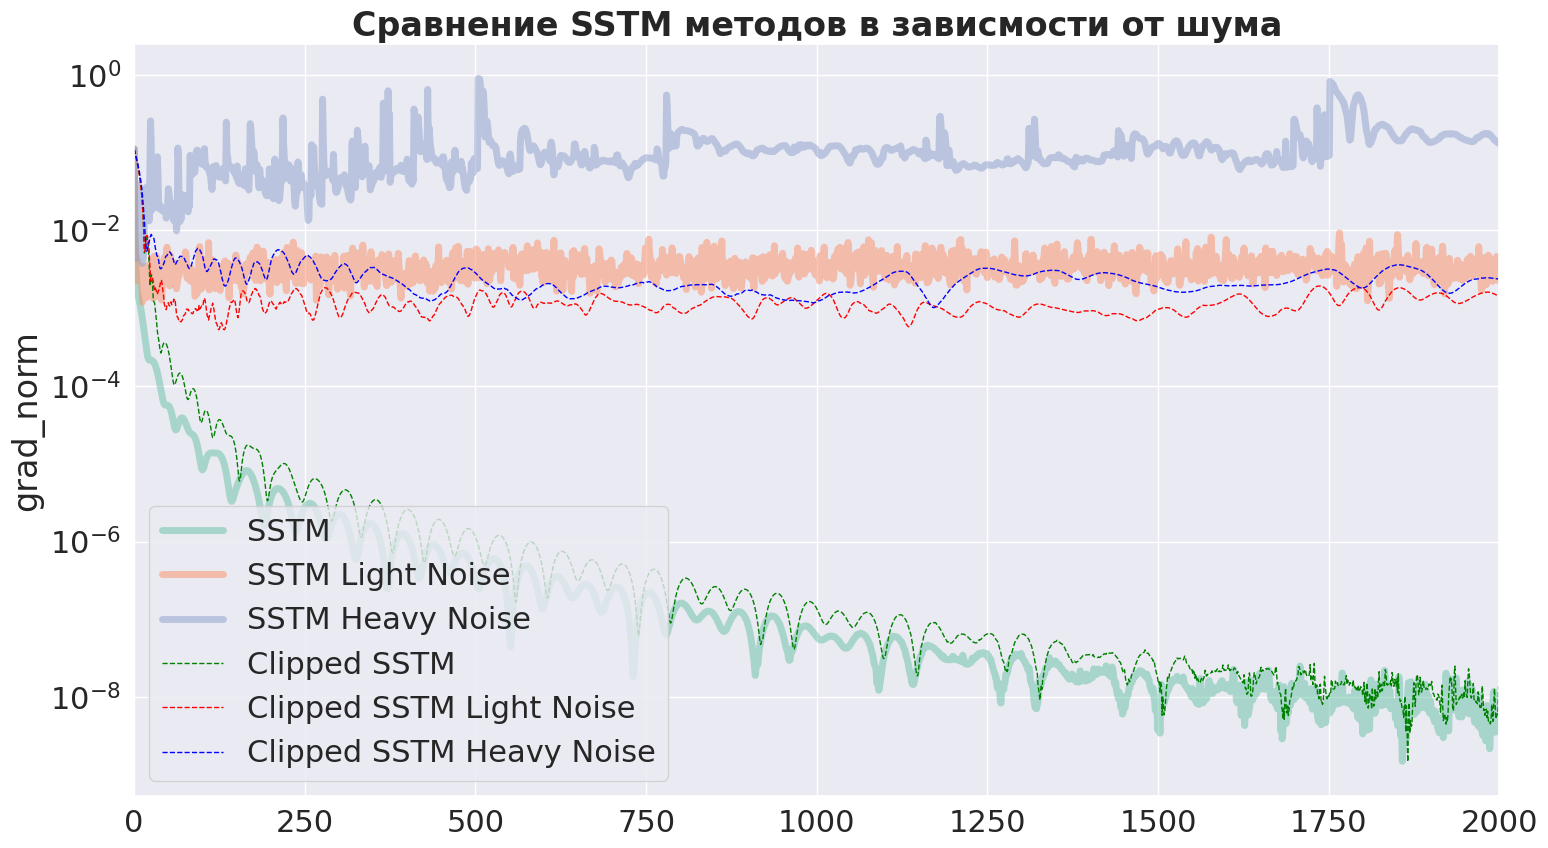

In [131]:
import seaborn as sns

sns.set_context("notebook")
sns.set_style("darkgrid")
sns.set(font_scale=2)

plt.figure(figsize=(16, 9))
plt.title("Сравнение SSTM методов в зависмости от шума", fontweight="bold")
start_pos = 0
plt.ylabel(r"grad_norm")
colors = sns.color_palette("Set2")[:3] + ["green", "red", "blue"]
for i, (name, data) in enumerate(save_grad.items()):
    linestyle = "--" if "Clipped" in name else '-'
    alpha = 1 if "Clipped" in name else 0.5
    lw = 1 if "Clipped" in name else 5
    plt.semilogy(data[start_pos:], label=name, alpha=alpha, lw=lw,
                 linestyle=linestyle, color=colors[i])
plt.xlim((0, N))
plt.legend()
plt.tight_layout()

plt.savefig('sstm_illustration.svg')

plt.show()